# Proyecto: Gimnasios Model Fitness

## Introducción:

Introducción al Proyecto de Retención de Clientes en un Gimnasio:

Este proyecto se enfoca en mejorar la retención de clientes en un gimnasio mediante el análisis de datos y la implementación de estrategias personalizadas. A través de técnicas de aprendizaje no supervisado, identificaremos patrones de comportamiento y agruparemos a los clientes en clústeres con características similares. El objetivo es comprender las diferencias en las tasas de cancelación entre estos grupos y, sobre esa base, formular recomendaciones específicas para aumentar la lealtad y mejorar la experiencia del cliente. Este enfoque personalizado permitirá al gimnasio implementar estrategias más efectivas, abordando las necesidades únicas de cada segmento de clientes y fomentando la retención a largo plazo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

##  Descargar los datos

In [2]:
file_path = '/datasets/gym_churn_us.csv'
data = pd.read_csv(file_path)
print(data.head())

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

In [3]:
# Verificar características ausentes
missing_values = data.isnull().sum()
print("Características Ausentes:")
print(missing_values)

# Estadísticas descriptivas
descriptive_stats = data.describe()
print("\nEstadísticas Descriptivas:")
print(descriptive_stats)


Características Ausentes:
gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Estadísticas Descriptivas:
            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000 

Los resultados muestran que no hay características ausentes en el conjunto de datos. Además, las estadísticas descriptivas proporcionan una visión general de las distribuciones y tendencias en los datos.

## Llevar a cabo el análisis exploratorio de datos (EDA)

In [4]:
# Observar los valores medios por grupos
churn_group_means = data.groupby('Churn').mean()
print("Valores Medios por Grupos:")
print(churn_group_means)


Valores Medios por Grupos:
         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0       

Ahora podemos observar las diferencias en los valores medios de las características entre los dos grupos (Churn=0 y Churn=1). Esto proporciona una buena visión general de las características que podrían estar relacionadas con la cancelación.

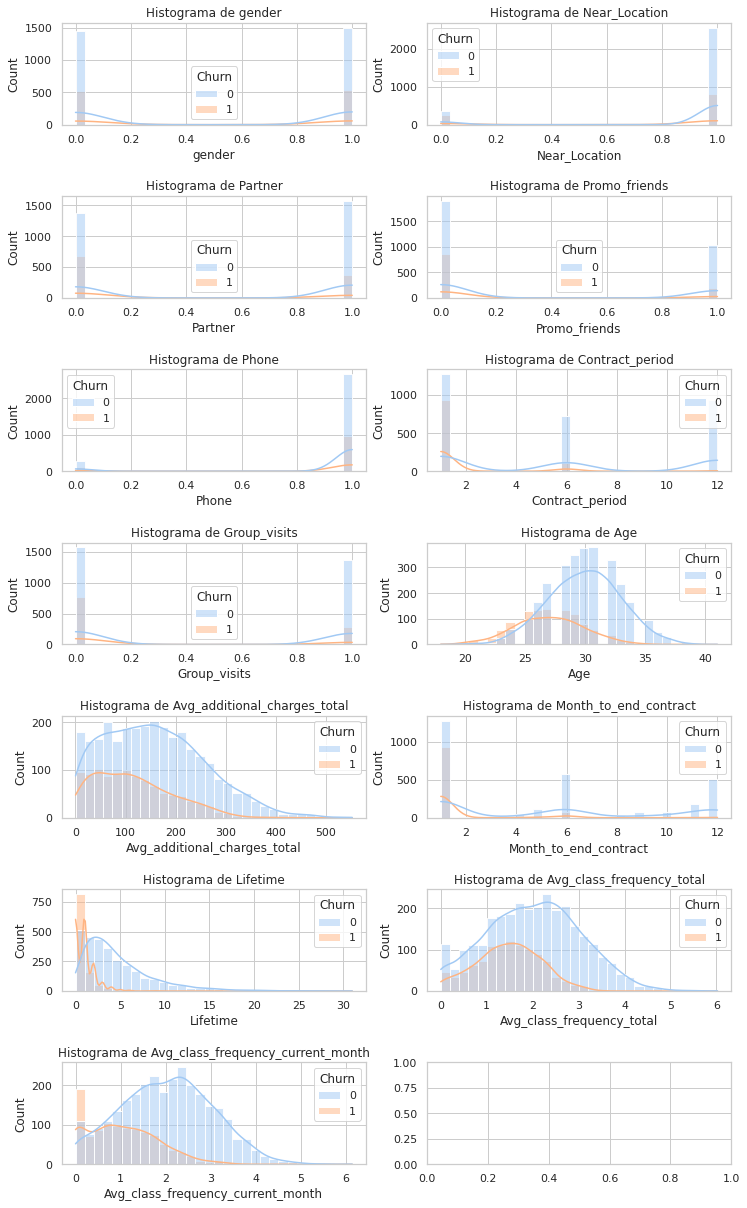

In [5]:
sns.set(style="whitegrid")

# Seleccionar características a visualizar
features_to_plot = data.columns.drop(['Churn'])

# Crear subplots
fig, axes = plt.subplots(nrows=(len(features_to_plot)//2) + len(features_to_plot)%2, ncols=2, figsize=(12, 3 * ((len(features_to_plot)//2) + len(features_to_plot)%2)))

fig.subplots_adjust(hspace=0.7)

# Iterar sobre las características y trazar los histogramas
for i, feature in enumerate(features_to_plot):
    sns.histplot(data, x=feature, hue='Churn', kde=True, ax=axes[i//2, i%2], bins=30, palette='pastel')
    axes[i//2, i%2].set_title(f'Histograma de {feature}')

plt.show()

Los usuarios que cancelan tienden a tener contratos más cortos, menor participación en promociones y sesiones grupales, y una menor frecuencia de visitas a clases.

La edad promedio de los usuarios que cancelan es menor, y gastan menos en servicios adicionales del gimnasio.

Estrategias de retención podrían centrarse en incentivar la participación en promociones y sesiones grupales, ofrecer contratos más atractivos, y adaptarse a las necesidades específicas de los usuarios más jóvenes.


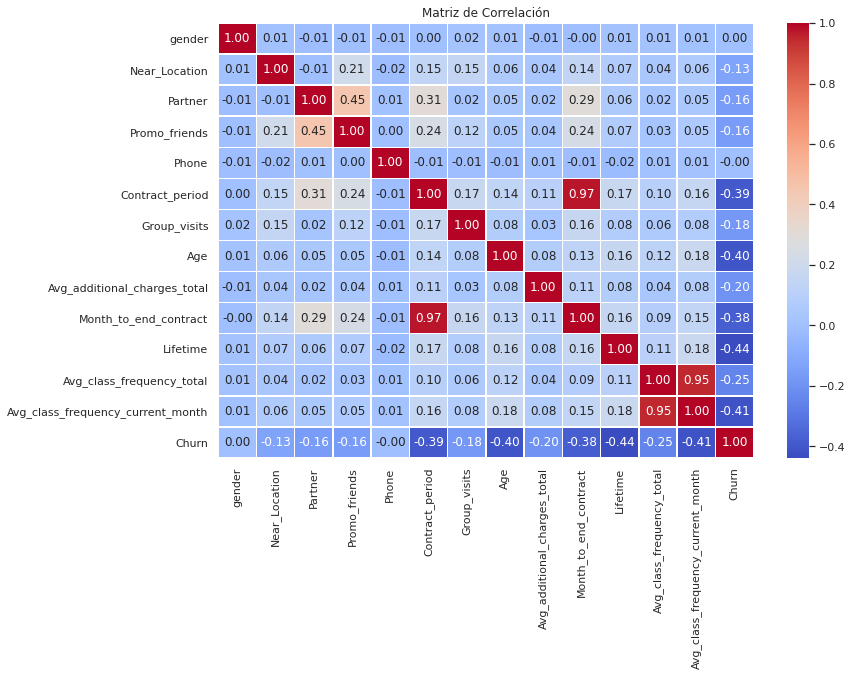

In [6]:
# Calcular la matriz de correlación
correlation_matrix = data.corr()
sns.set(style="white")

# Mapa de calor para la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

La matriz de correlación proporciona información sobre la relación lineal entre pares de variables. Algunos puntos clave de la matriz son:

Near_Location y Churn: Hay una correlación negativa significativa (-0.13), lo que sugiere que los clientes que viven o trabajan más lejos del gimnasio son más propensos a cancelar su membresía.

Age y Churn: Existe una correlación negativa fuerte (-0.40), indicando que los clientes más jóvenes tienden a ser más propensos a cancelar.

Contract_period y Churn: La duración del contrato (Contract_period) tiene una correlación negativa sustancial con la cancelación (Churn) (-0.39), lo que sugiere que los contratos más cortos están asociados con una mayor probabilidad de cancelación.

Avg_class_frequency_total y Avg_class_frequency_current_month: Ambas tienen una fuerte correlación positiva (0.95), lo cual es esperado ya que representan medidas similares de la frecuencia de las visitas a clases.

## Construir un modelo para predecir la cancelación de usuarios


In [7]:
# Separar las características (X) y la variable objetivo (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# Dividir los datos en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)

Forma de X_train: (3200, 13)
Forma de X_val: (800, 13)
Forma de y_train: (3200,)
Forma de y_val: (800,)


In [8]:
# Modelo de regresión logística
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

# Modelo de bosque aleatorio
forest_model = RandomForestClassifier(random_state=42)
forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Predicciones de los modelos en el conjunto de validación
logistic_preds = logistic_model.predict(X_val)
forest_preds = forest_model.predict(X_val)

# Calcular métricas para regresión logística
logistic_accuracy = accuracy_score(y_val, logistic_preds)
logistic_precision = precision_score(y_val, logistic_preds)
logistic_recall = recall_score(y_val, logistic_preds)

# Calcular métricas para bosque aleatorio
forest_accuracy = accuracy_score(y_val, forest_preds)
forest_precision = precision_score(y_val, forest_preds)
forest_recall = recall_score(y_val, forest_preds)

# Mostrar resultados
print("Métricas para Regresión Logística:")
print(f"Exactitud: {logistic_accuracy:.3f}")
print(f"Precisión: {logistic_precision:.3f}")
print(f"Recall: {logistic_recall:.3f}")
print("\nMétricas para Bosque Aleatorio:")
print(f"Exactitud: {forest_accuracy:.3f}")
print(f"Precisión: {forest_precision:.3f}")
print(f"Recall: {forest_recall:.3f}")


Métricas para Regresión Logística:
Exactitud: 0.916
Precisión: 0.873
Recall: 0.782

Métricas para Bosque Aleatorio:
Exactitud: 0.910
Precisión: 0.849
Recall: 0.782


Ambos modelos, la Regresión Logística y el Bosque Aleatorio, muestran un rendimiento sólido en la predicción de la cancelación de usuarios. Aunque la Regresión Logística tiene una precisión ligeramente superior, la elección entre los modelos dependerá de las necesidades y preferencias específicas del negocio.

In [10]:
# Dejar de lado la columna con datos sobre la cancelación
X = data.drop('Churn', axis=1)

# Inicializar el StandardScaler
scaler = StandardScaler()

# Estandarizar los datos
X_scaled = scaler.fit_transform(X)

# Crear un DataFrame con los datos estandarizados
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print(X_scaled_df.head())

     gender  Near_Location   Partner  Promo_friends     Phone  \
0  0.979706       0.427881  1.026861       1.497161 -3.059852   
1 -1.020715       0.427881 -0.973842      -0.667931  0.326813   
2 -1.020715       0.427881  1.026861      -0.667931  0.326813   
3 -1.020715       0.427881  1.026861       1.497161  0.326813   
4  0.979706       0.427881  1.026861       1.497161  0.326813   

   Contract_period  Group_visits       Age  Avg_additional_charges_total  \
0         0.289890      1.194032 -0.056554                     -1.377531   
1         1.608822      1.194032  0.557327                     -0.350213   
2        -0.809219     -0.837498 -0.363494                     -0.181592   
3         1.608822      1.194032  1.171208                     -0.874722   
4        -0.809219     -0.837498 -0.977375                      0.533700   

   Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
0               0.161605 -0.193329                  -1.911920   
1               1.8319

Los datos han sido estandarizados, lo que significa que cada característica ahora tiene una media de 0 y una desviación estándar de 1. Estos valores normalizados facilitan la comparación entre las diferentes características. Podemos observar cómo los valores originales se han transformado a través del proceso de estandarización.

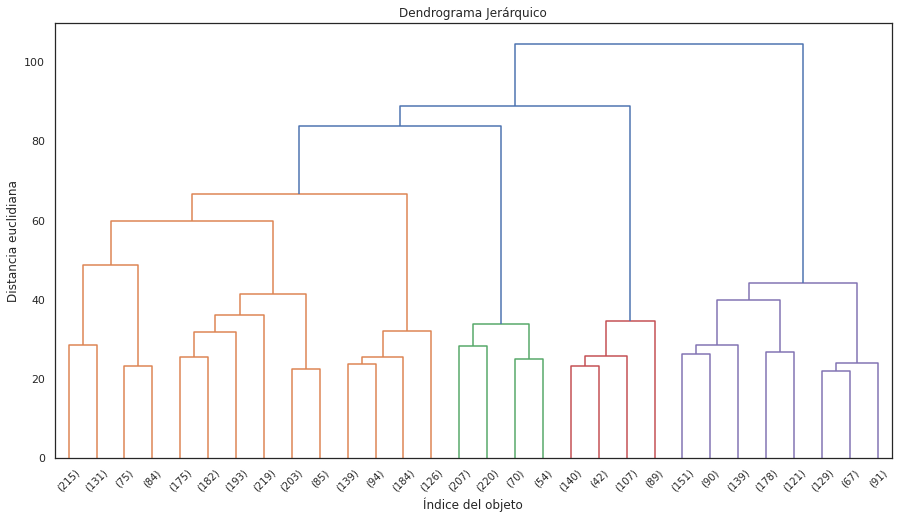

In [11]:
# Estandarizar los datos
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data.drop('Churn', axis=1))

# Calcular la matriz de enlace usando la distancia euclidiana y el método completo
linked = linkage(data_standardized, method='ward', metric='euclidean')

# Crear un dendrograma
plt.figure(figsize=(15, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, truncate_mode='lastp', p=30)
plt.title('Dendrograma Jerárquico')
plt.xlabel('Índice del objeto')
plt.ylabel('Distancia euclidiana')
plt.show()


In [12]:
# Crear el modelo K-means con 5 clústeres
kmeans = KMeans(n_clusters=5, random_state=42)

# Entrenar el modelo
clusters = kmeans.fit_predict(data_standardized)

# Agregar la columna de clústeres al conjunto de datos original
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = clusters

In [13]:
# Visualizar los valores medios de características para los clústeres
cluster_summary = data_with_clusters.groupby('Cluster').mean()
print(cluster_summary)

           gender  Near_Location   Partner  Promo_friends  Phone  \
Cluster                                                            
0        0.502370       0.949447  0.829384       0.998420    1.0   
1        0.554556       0.849269  0.263217       0.052868    1.0   
2        0.499422       0.937572  0.737572       0.478613    1.0   
3        0.485738       0.718011  0.299919       0.018745    1.0   
4        0.523316       0.862694  0.471503       0.305699    0.0   

         Contract_period  Group_visits        Age  \
Cluster                                             
0               3.097946      0.448657  29.104265   
1               2.606299      0.436445  30.008999   
2              11.854335      0.546821  29.905202   
3               1.914425      0.276284  28.083945   
4               4.777202      0.427461  29.297927   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
Cluster                                                                  
0  

Observando los valores medios de las características para cada clúster, se puede observar lo siguiente:


Cluster 0: Este grupo tiene una tasa de abandono (Churn) del 24.6%, con una duración de contrato más corta, un número más bajo de visitas grupales y una frecuencia de visitas más baja en comparación con otros clústeres.


Cluster 1: Este grupo tiene la tasa de abandono más baja (8.99%). También muestra una duración de contrato más corta, pero con una mayor frecuencia de visitas totales y en el mes actual en comparación con el Cluster 0.


Cluster 2: Este grupo tiene la tasa de abandono más baja (2.20%). Muestra la duración de contrato más larga, una mayor proporción de personas con socios y un mayor gasto adicional promedio en comparación con otros clústeres.


Cluster 3: Este grupo tiene una tasa de abandono alta (57.29%). Se caracteriza por la duración de contrato más corta, la menor frecuencia de visitas totales y en el mes actual, y un gasto adicional promedio más bajo.


Cluster 4: Este grupo tiene una tasa de abandono del 26.68%. Muestra una duración de contrato moderada, una proporción moderada de personas con socios y un gasto adicional promedio moderado.

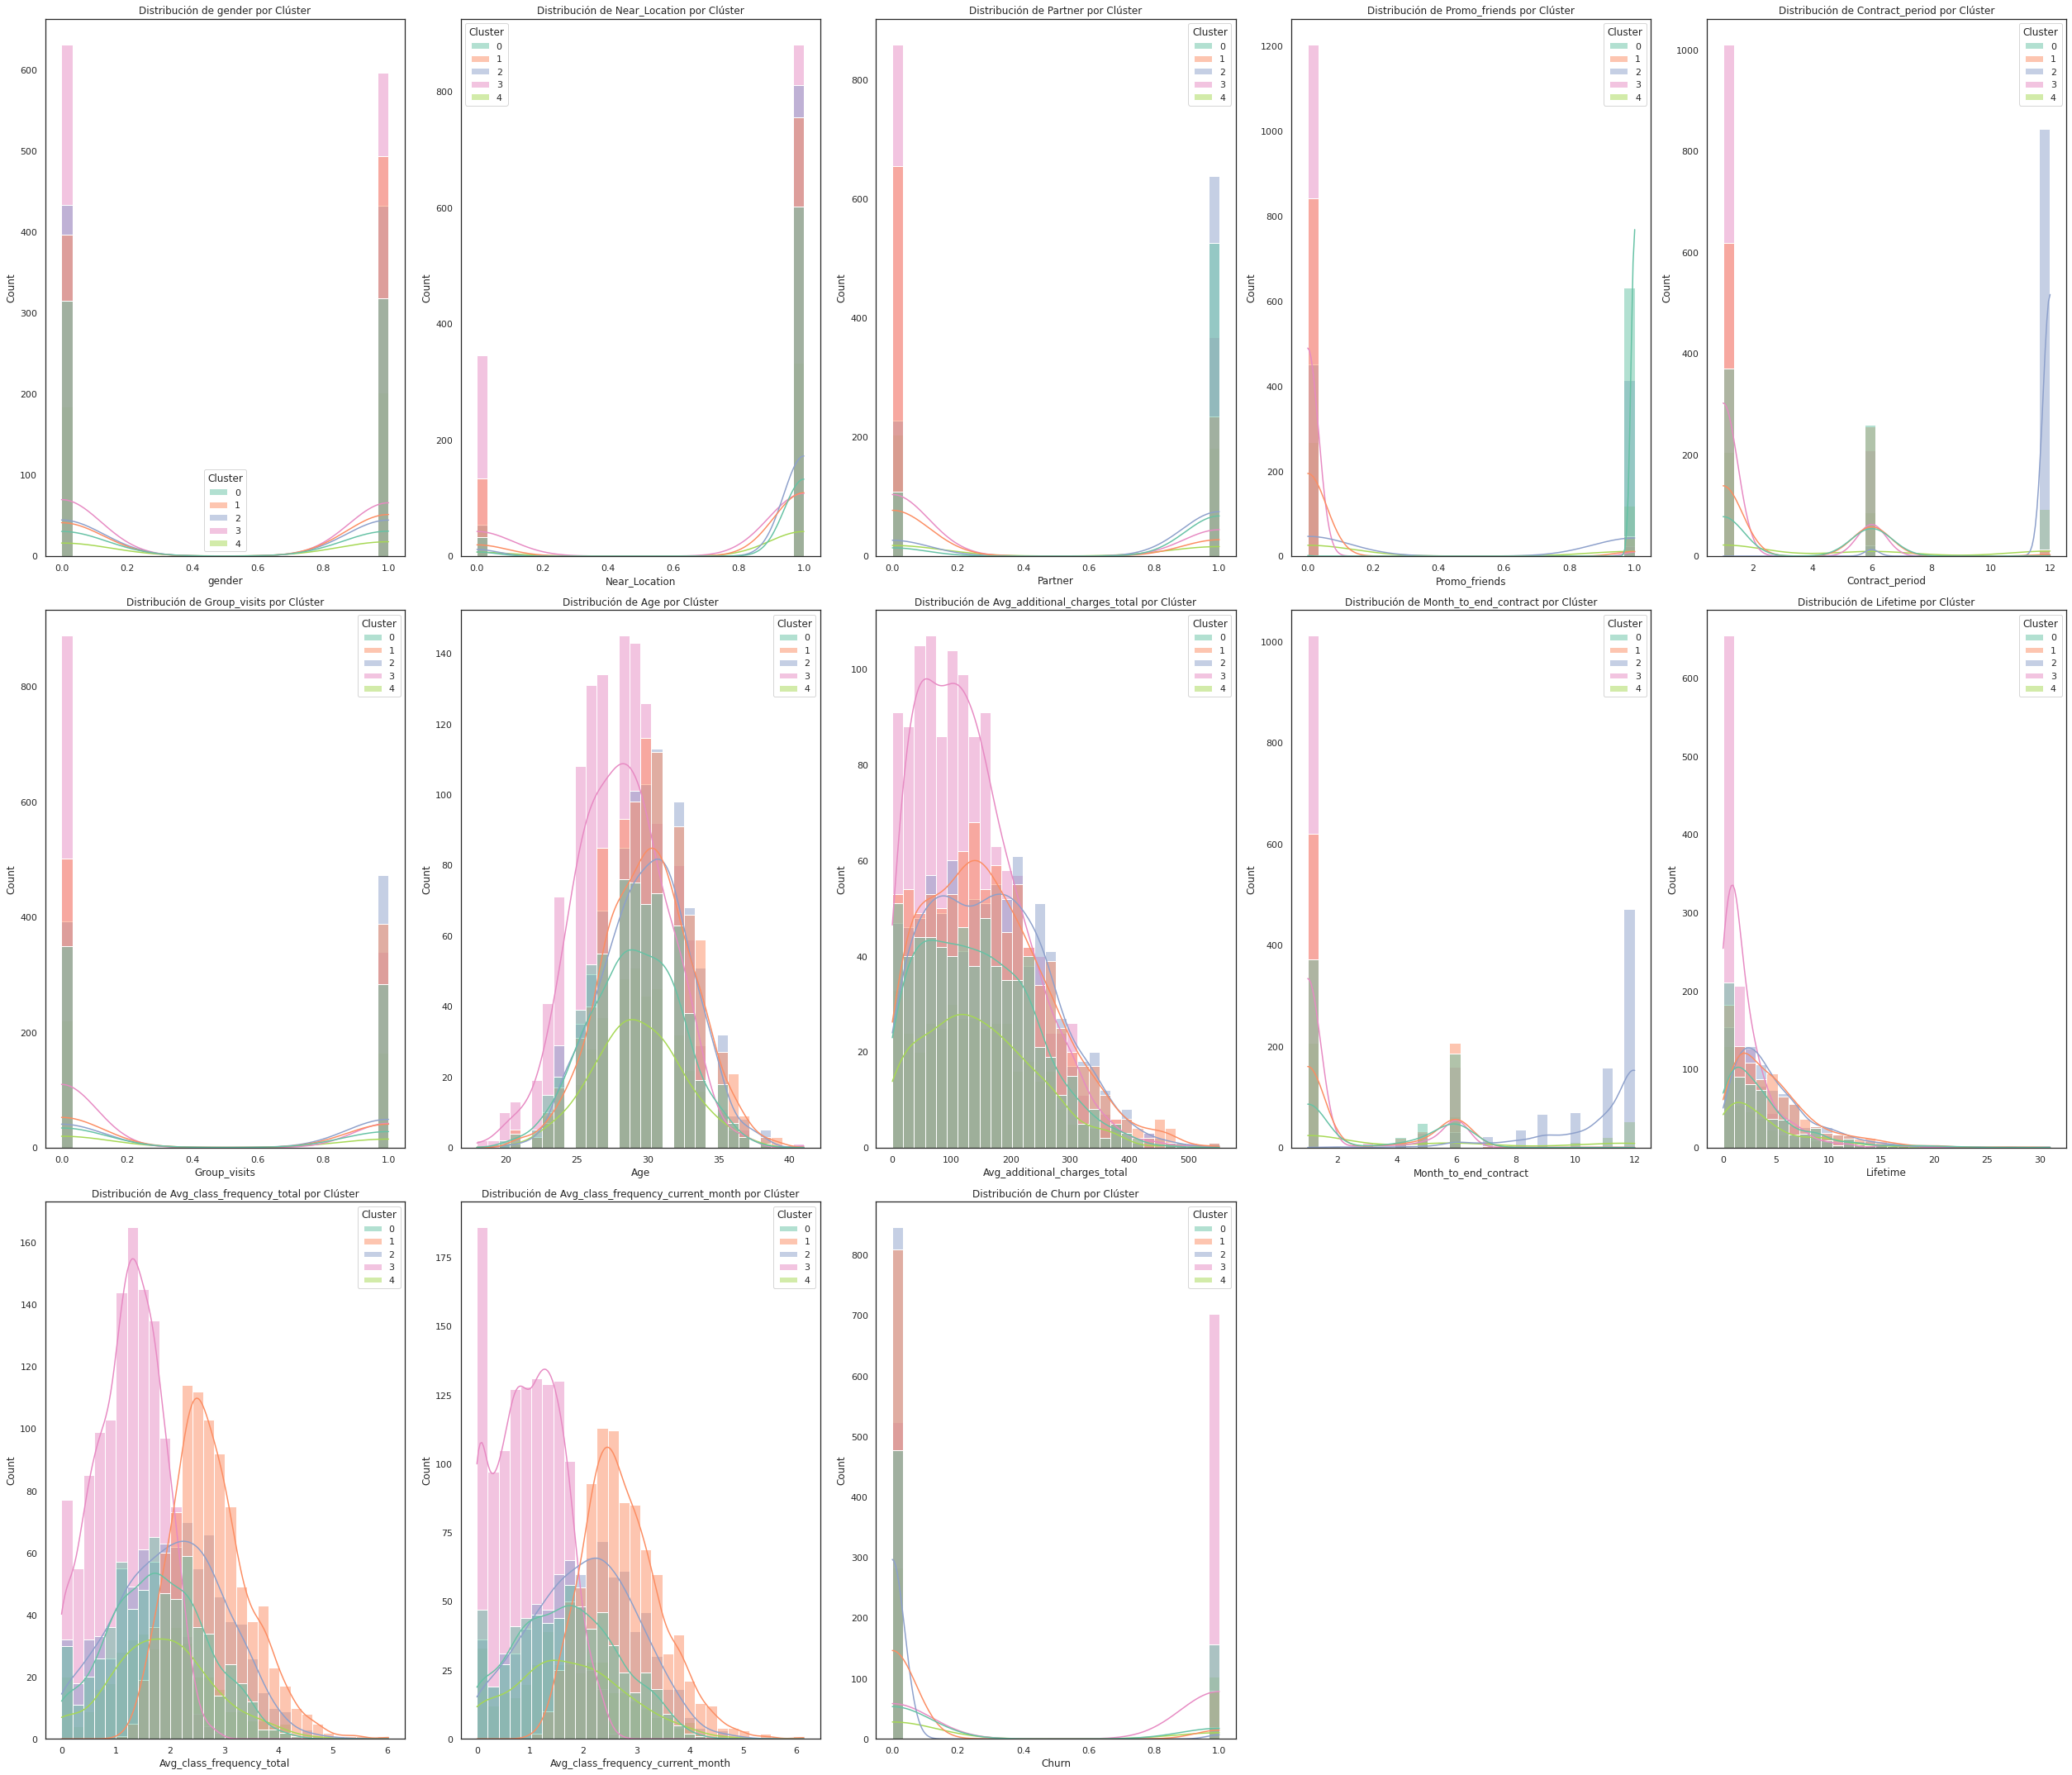

In [14]:
cluster_palette = sns.color_palette("Set2", n_colors=len(set(data_with_clusters['Cluster'])))

features_to_plot = data_with_clusters.columns.drop(['Churn'])

# Calcular la varianza por clúster para cada característica
variances = data_with_clusters.groupby('Cluster').var()

# Seleccionar características con varianza suficientemente alta
selected_features = variances.columns[variances.min(axis=0) > 0]

# Filtrar las características a visualizar
features_to_plot = selected_features

# Crear gráficos para cada característica
plt.figure(figsize=(35, 30))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 5, i)
    sns.histplot(data=data_with_clusters, x=feature, hue='Cluster', kde=True, palette=cluster_palette, bins=30)
    plt.title(f'Distribución de {feature} por Clúster')

plt.tight_layout()
plt.show()

Podemos observar que:

Cluster 2 tiene valores altos en casi todas las características, especialmente en Contract_period, Month_to_end_contract, Lifetime, Avg_class_frequency_total, y Avg_class_frequency_current_month. Este grupo parece tener clientes que han estado en el gimnasio durante un período prolongado, asisten con frecuencia a clases y tienen contratos de mayor duración.


Cluster 3 tiene valores bajos en Near_Location, Partner, Promo_friends, Phone, Contract_period, Group_visits, Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total, y Avg_class_frequency_current_month. Este grupo podría representar a clientes que no están tan comprometidos y participativos en las ofertas del gimnasio.


Cluster 1 muestra una alta participación en las ofertas de amigos (Promo_friends), lo que podría indicar que este grupo es sensible a las recomendaciones y ofertas promocionales.


Cluster 0 y Cluster 4 tienen valores intermedios en muchas características, sin destacar especialmente en ninguna de ellas.

In [15]:
# Calcular la tasa de cancelación para cada clúster
churn_rate_by_cluster = data_with_clusters.groupby('Cluster')['Churn'].mean()
print(churn_rate_by_cluster)

Cluster
0    0.246445
1    0.089989
2    0.021965
3    0.572942
4    0.266839
Name: Churn, dtype: float64


Los grupos difieren significativamente en términos de tasa de cancelación.

Propensos a irse (Alta tasa de cancelación):

Cluster 3: Con una tasa de cancelación del 57.29%, este grupo muestra una alta propensión a cancelar. Los clientes en este clúster son los menos leales y requieren una atención especial para retenerlos.

Cluster 0: Con una tasa de cancelación del 24.64%, este grupo también tiene una propensión significativa a irse, aunque no tan alta como en el Cluster 3.

Cluster 4: Con una tasa de cancelación del 26.68%, este grupo también muestra una propensión considerable a cancelar, aunque menor que el Cluster 3.

Leales (Baja tasa de cancelación):

Cluster 2: Con la tasa de cancelación más baja, solo el 2.20%, este grupo es el más leal y muestra una fuerte retención de clientes.

Cluster 1: Con una tasa de cancelación del 8.99%, este grupo también se considera leal en comparación con los demás, aunque no tan leal como el Cluster 2.


En resumen, algunos grupos son propensos a irse, especialmente los clústeres 3, 0 y 4, mientras que los clústeres 2 y 1 son más leales y muestran tasas de cancelación significativamente más bajas.

## Conclusiones y Recomendaciones:

Segmentación de Clientes:

1.-La segmentación efectiva de clientes revela diferentes comportamientos y preferencias. Utilizar enfoques personalizados para cada segmento puede mejorar la retención.
Identificación de Grupos de Riesgo:

2.-Los clústeres con tasas de cancelación más altas (Cluster 3, 0, y 4) deben ser el foco principal de esfuerzos de retención. Estrategias específicas, como descuentos, programas de fidelización o encuestas de satisfacción, pueden aplicarse a estos grupos.
Fomentar la Lealtad (Cluster 2 y 1):

3.-Dado que los Clústeres 2 y 1 muestran tasas de cancelación significativamente más bajas, las estrategias de fidelización, como recompensas exclusivas, programas VIP o servicios personalizados, pueden fortalecer la lealtad de estos grupos.
Mejorar la Experiencia del Cliente:

4.-Enfoques centrados en mejorar la experiencia del cliente, como clases personalizadas, promociones especiales y seguimiento proactivo, pueden influir positivamente en la retención en todos los grupos.
Análisis Continuo y Ajustes:

5.-Mantener un análisis continuo de la efectividad de las estrategias y realizar ajustes según sea necesario es crucial. Las preferencias y comportamientos de los clientes pueden cambiar con el tiempo, por lo que la estrategia de retención debe evolucionar en consecuencia.